In [1]:
%matplotlib inline
import pandas
import os
import collections
import numpy

from train_test import find_files, parse_dates, load_series, load_data, separate_output

path = "../data/v2/train_set/"
power_data = load_series(find_files(path, "power"), resample_interval="1H")

Using Theano backend.


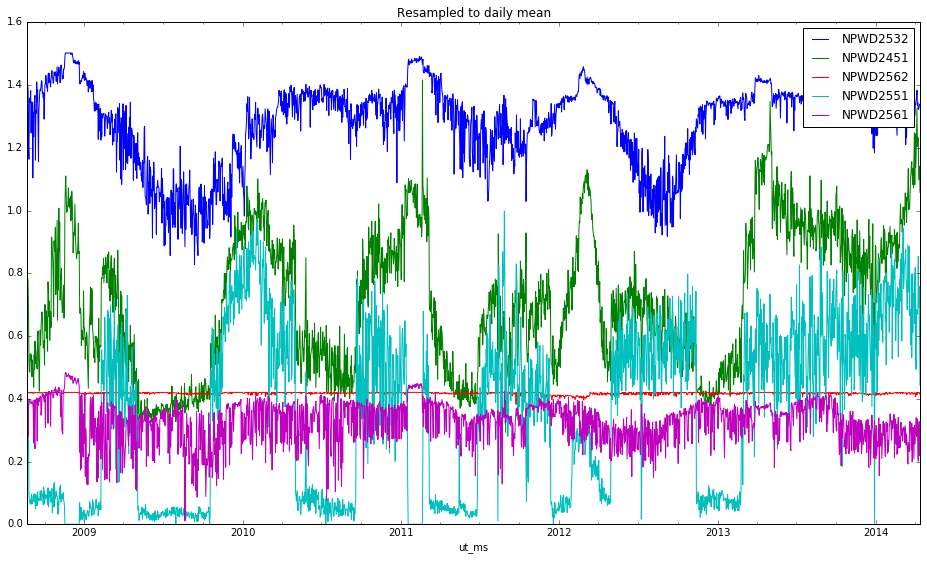

In [2]:
col_weights = power_data.mean(axis=0) #+ power_data.std(axis=0)
col_weights.sort_values(ascending=False)

ax = power_data[col_weights.sort_values(ascending=False)[:5].index].resample("1D").mean().plot(figsize=(16, 9))
ax.set_title("Resampled to daily mean")
ax.legend(loc="upper right")
ax

In [3]:
pandas.set_option("display.max_rows", 500)
saaf_data = load_series(find_files(path, "saaf"))
evtf_data = load_series(find_files(path, "evtf"))
dmop_data = load_series(find_files(path, "dmop"))
ftl_data = load_series(find_files(path, "ftl"))

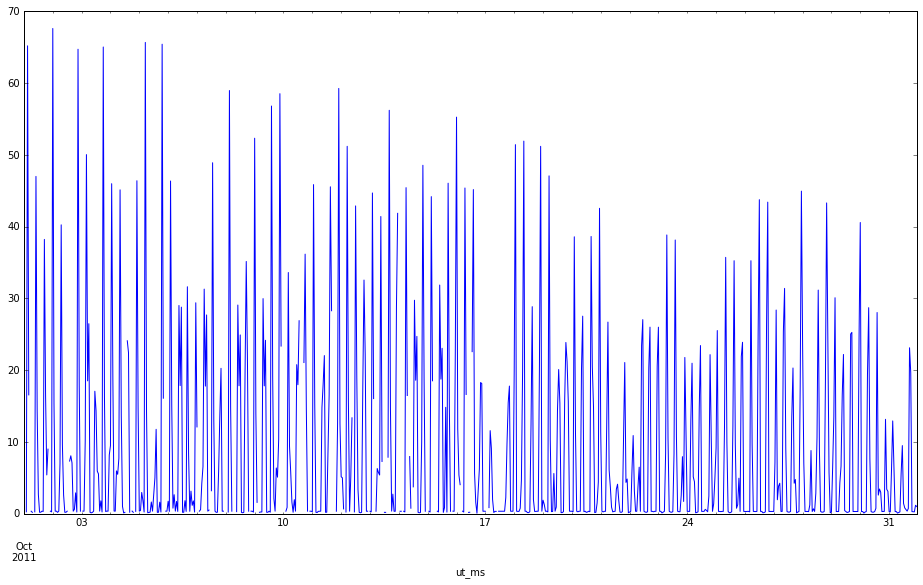

In [4]:
saaf_data.sa["2011-10"].resample("1H").mean().plot(figsize=(16,9))

In [18]:
evtf_data.description.str.extract("MRB_[AL]OS_(\\d+)", expand=False).value_counts()

00    9744
10    7948
Name: description, dtype: int64